In [1]:
import numpy as np
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

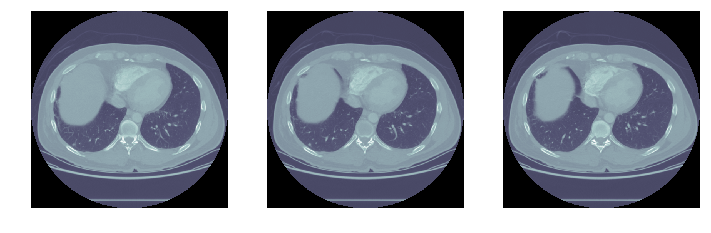

In [2]:
working_path = "/home/jenifferwu/IMAGE_MASKS_DATA/Test/"
img_file = working_path + "images_0004_0023.npy"
imgs_to_process = np.load(img_file).astype(np.float64)
fig = plt.figure(figsize=(12, 4))
for i in range(3):
  ax = fig.add_subplot(1, 3, i+1)
  ax.imshow(imgs_to_process[i, :, :], 'bone')
  ax.set_axis_off()

In [3]:
i = 0
img = imgs_to_process[i]
#Standardize the pixel values
mean = np.mean(img)
std = np.std(img)
img = img-mean
img = img/std
# Find the average pixel value near the lungs
#　to renormalize washed out images
middle = img[100:400, 100:400]
mean = np.mean(middle)
max = np.max(img)
min = np.min(img)
# To improve threshold finding, I'm moving the
#　underflow and overflow on the pixel spectrum
img[img==max]=mean
img[img==min]=mean
# Using Kmeans to separate foreground (radio-opaque tissue)
#　and background (radio transparent tissue ie lungs)
# Doing this only on the center of the image to avoid
#　the non-tissue parts of the image as much as possible
kmeans = KMeans(n_clusters=2).fit(np.reshape(middle, [np.prod(middle.shape), 1]))
centers = sorted(kmeans.cluster_centers_.flatten())
threshold = np.mean(centers)
thresh_img = np.where(img<threshold, 1.0, 0.0)  # threshold the image

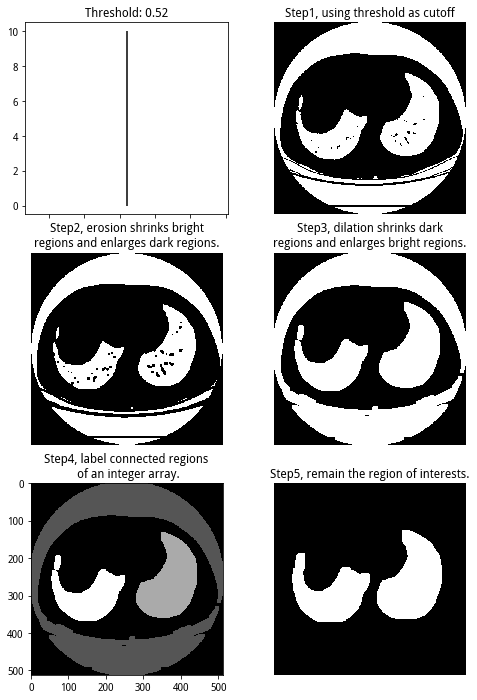

In [4]:
# 对一张图中所有像素点的亮度做概率密度分布 , 用竖线标注阈值所在
fig = plt.figure(figsize=(8, 12))
ax1 = fig.add_subplot(321)
# sns.distplot(middle.ravel(), ax=ax1)
ax1.vlines(x=threshold, ymax=10, ymin=0)
ax1.set_title('Threshold: %1.2F' % threshold)
ax1.set_xticklabels([])

# 展示阈值对图像切割的结果。小于阈值的点标注为 1 ,白色。大于阈值的点标注为 0 ,黑色。
ax2 = fig.add_subplot(322)
ax2.imshow(thresh_img, "gray")
ax2.set_axis_off()
ax2.set_title('Step1, using threshold as cutoff')

# 增大黑色部分(非 ROI )的区域,使之尽可能的连在一起
eroded = morphology.erosion(thresh_img, np.ones([4, 4]))
ax3 = fig.add_subplot(323)
ax3.imshow(eroded, "gray")
ax3.set_axis_off()
ax3.set_title('Step2, erosion shrinks bright\nregions and enlarges dark regions.')

# 增大白色部分( ROI )的区域,尽可能的消除面积较小的黑色区域
dilation = morphology.dilation(eroded, np.ones([10, 10]))
ax4 = fig.add_subplot(324)
ax4.imshow(dilation, "gray")
ax4.set_axis_off()
ax4.set_title('Step3, dilation shrinks dark\nregions and enlarges bright regions.')

# 上一张图中共有三片连续区域,即最外层的体外区域,内部的肺部区域,以及二者之间的身体轮廓区域。这里将其分别标出
labels = measure.label(dilation)
ax5 = fig.add_subplot(325)
ax5.imshow(labels, "gray")
#ax5.set_axis_off()
ax5.set_title('Step4, label connected regions\n of an integer array.')

# 提取 regions 信息,这张图片的 region 的 bbox 位置分别在 [[0,0,512,512],[141, 86, 396, 404]],
# 分别对应 体外 + 轮廓 以及 肺部区域的左上角、右下角坐标。
# 于是这里通过区域的宽度 B[2]-B[0] 、高度 B[3]-B[1]
# 以及距离图片上下的距离 B[0]>40 and B[2]<472,
# 最终保留需要的区域。
regions = measure.regionprops(labels)
good_labels = []
for prop in regions:
  B = prop.bbox
  if B[2]-B[0] < 475 and B[3]-B[1] < 475 and B[0] > 40 and B[2] < 472:
    good_labels.append(prop.label)

mask = np.zeros_like(labels)
for N in good_labels:
  mask = mask + np.where(labels == N, 1, 0)

mask = morphology.dilation(mask, np.ones([10, 10]))  # one last dilation

ax6 = fig.add_subplot(326)
ax6.imshow(mask, "gray")
ax6.set_axis_off()
ax6.set_title('Step5, remain the region of interests.')

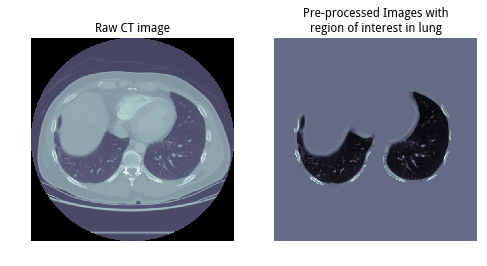

In [5]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(imgs_to_process[0, :, :], 'bone')
ax1.set_axis_off()
ax1.set_title("Raw CT image")
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(imgs_to_process[0, :, :] * mask, 'bone')
ax2.set_axis_off()
ax2.set_title("Pre-processed Images with\nregion of interest in lung")

In [6]:
import cv2
import os

for i in range(len(imgs_to_process)):
  new_img= imgs_to_process[i, :, :] * mask
  filename = img_file.replace(working_path, "")
  new_name = filename.replace(".npy", "") + "_%s.jpg" % (i)
  image_path = working_path + "JPEG/"
  print new_name, image_path
  cv2.imwrite(os.path.join(image_path, new_name), new_img)

images_0004_0023_0.jpg /home/jenifferwu/IMAGE_MASKS_DATA/Test/JPEG/
images_0004_0023_1.jpg /home/jenifferwu/IMAGE_MASKS_DATA/Test/JPEG/
images_0004_0023_2.jpg /home/jenifferwu/IMAGE_MASKS_DATA/Test/JPEG/
